# The  Research  Space

"Here we use a large dataset of scholarly publications disambiguated at the individual level to create a map of science — or research  space — where links connect pairs of fields based on the probability that an individual has published in both of them."
[Original Article](https://arxiv.org/ftp/arxiv/papers/1602/1602.08409.pdf)

[Artigo suplementar](https://link.springer.com/content/pdf/10.1140/epjds/s13688-019-0210-z.pdf)

In [126]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from collections import Counter
import networkx as nx
import pandas as pd
import numpy as np
import unidecode
import re

In [154]:
plt.rcParams["figure.figsize"] = (10,50)

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Our data

PRECISO CHECAR O PARSER NOVAMENTE. ALGUNS ANOS APARECERAM COMO 'rint' OU 'onic'. E EM ALGUNS ARTIGOS O NÚMERO DE AUTORES FOI ZERO.

Todas as publicações

In [ ]:
articles = pd.read_csv("../dataset/lattes_categories.csv", sep=";sep;", engine="python")
articles = articles[(articles["ano"] != 'rint') & (articles["ano"] != 'onic')]
articles.head()

Dados das categorias:

O dicionário abaixo é a classificação intermediária de acordo com o Scopus

In [4]:
clss = dict()
clss[10] = "multidisciplinary"
clss[11] = "agricultural and biological sciences"
clss[12] = "arts and humanities"
clss[13] = "biochemistry, genetics and molecular biology"
clss[14] = "business, management and accounting"
clss[15] = "chemical engineering"
clss[16] = "chemistry"
clss[17] = "computer science"
clss[18] = "decision sciences"
clss[19] = "earth and planetary sciences"
clss[20] = "economics, econometrics and finance"
clss[21] = "energy"
clss[22] = "engineering"
clss[23] = "environmental science"
clss[24] = "immunology and microbiology"
clss[25] = "materials science"
clss[26] = "mathematics"
clss[27] = "medicine"
clss[28] = "neuroscience"
clss[29] = "nursing"
clss[30] = "pharmacology, toxicology and pharmaceutics"
clss[31] = "physics and astronomy"
clss[32] = "psychology"
clss[33] = "social sciences"
clss[34] = "veterinary"
clss[35] = "dentistry"
clss[36] = "health professions"

Podemos ler e adicionar uma nova coluna de classificação

In [5]:
areas = pd.read_csv("../dataset/SJR/areas.txt", sep=";")
areas["Field"] = areas["Field"].apply(lambda x: x.strip().lower())
areas["Subject area"] = areas["Subject area"].apply(lambda x: x.strip().lower())
areas["Classification"] = areas["Code"].apply(lambda x: clss[int(str(x)[:2])])
areas.head()

,Code,Field,Subject area,Classification
0,1000,multidisciplinary,health sciences,multidisciplinary
1,1100,general agricultural and biological sciences,life sciences,agricultural and biological sciences
2,1101,agricultural and biological sciences (miscella...,life sciences,agricultural and biological sciences
3,1102,agronomy and crop science,life sciences,agricultural and biological sciences
4,1103,animal science and zoology,life sciences,agricultural and biological sciences


Por fim, temos que adicionar algumas áreas que não foram cadastradas

In [6]:
areas = areas.append({'Field': 'e-learning', 'Subject area': "social sciences & humanities",
                      "Classification": "social sciences"} , ignore_index=True)
areas = areas.append({'Field': 'nanoscience and nanotechnology', 'Subject area': "physical sciences",
                      "Classification": "materials science"} , ignore_index=True)
areas = areas.append({'Field': 'social work', 'Subject area': "social sciences & humanities",
                      "Classification": "social sciences"} , ignore_index=True)
areas = areas.append({'Field': 'sports science', 'Subject area': "health sciences",
                      "Classification": "health professions"} , ignore_index=True)

Instituição do pesquisador, caso queiramos agregar os dados

In [55]:
def ops(s):
    s = re.sub(r"\s?\(.*\)", "", s)
    s = unidecode.unidecode(s)
    s = s.lower()
    s = re.sub(",", " ", s)
    s = re.sub("\.", " ", s)
    s = re.sub(";", " ", s)
    s = re.sub("\s+", " ", s)
    s = s.strip()
    
    return s

In [71]:
bio = pd.read_csv("../dataset/lattes/pesquisadores.csv", sep=";sep;", engine="python").dropna(subset=['id_pesquisador'])
bio = bio[bio["id_pesquisador"] != "None"]
bio = bio.fillna("none")
bio["nome_instituicao"] = bio["nome_instituicao"].astype(str).apply(lambda x: ops(x))
bio["cep_instituicao"] = bio["cep_instituicao"].astype(str).apply(lambda x: re.sub("\-", "", x))
bio.head()

,id_pesquisador,nome_instituicao,cep_instituicao
0,0099900328713566,universidade federal do oeste da bahia,47808021
1,0026846500140475,instituto federal de educacao ciencia e tecnol...,49032490
2,0084190106475603,universidade federal do rio de janeiro,21945970
3,0027688823067577,instituto federal de educacao ciencia e tecnol...,45320000
4,0017466571949740,ministerio publico do estado do rio de janeiro,20020080


### Filtering

"We filter this dataset by focusing only on scholars with less than fifty publications in each year, because those with more than fifty publications tend to have many publications that are miss-assigned and are not theirs"

VOU IGNORAR PORQUE NO LATTES É O USUÁRIO QUEM COLOCA.

### Research Space

" $\phi_{ff'}(T)$ is  the  adjacency  matrix  representing  the  research  space expressed  by  the  career trajectory of scientists in our dataset observed up to time T. "

Get all the categories from an article

In [ ]:
def catg(s):
    return [re.sub(r"\s?\(Q[1-9]\)", "", x).strip().lower() for x in s.split(";")]

Create a dict to represent the X matrix

In [ ]:
def X(t):
    x = dict()
    for _, row in articles.iterrows():
        if int(row["ano"]) < t:
            fs = catg(row["catg"])
            nf = len(fs)
            for field in fs:
                
                if row["num"] == 0:
                    continue
                
                if (row["pesq"], field) in x:
                    x[(row["pesq"], field)] += 1/(nf * row["num"])
                else:
                    x[(row["pesq"], field)] = 1/(nf * row["num"])
    
    print("X done")
    return x

Create a dict to represent the P matrix

In [ ]:
def P(t):
    x = X(t)
    p = dict()
    
    for sf in x:
        if x[sf] > 0.1:
            p[sf] = 1
            
    print("P done")
    return [p, x]

Create the M matrix

In [ ]:
def M(t):
    p, x = P(t)
    s = set()
    f = set()
    
    for sf in p:
        s.add(sf[0])
        f.add(sf[1])
        
    of = sorted(list(f))
    indices = {u: v for v, u in enumerate(of)}
    n = len(of)
    m = np.zeros((n,n))
    
    for i in range(len(of)):
        for j in range(i+1, len(of)):
            for k in s:
                if (k,of[i]) in p and (k,of[j]) in p:
                    m[i,j] += 1
                    m[j,i] += 1
                    
    print("M done")
    return [m, p, of, x]

Create the phi matrix

In [ ]:
def phi(t):
    m, p, of, x = M(t)
    indices = dict()
    sums = np.zeros(len(m))
    
    for sf in p:
        if sf[1] not in indices:
            indices[sf[1]] = of.index(sf[1])
        sums[indices[sf[1]]] += 1

    phi = m.copy()
    for i in range(len(m)):
        phi[:,i] /= sums[i]
    
    print("phi done")
    return [phi, of, x]

Salvar só pra ter certeza né. As etapas do X e do M são bastante demoradas.

In [ ]:
k, of, x = phi(2011)
np.save("../dataset/phi_matrix_2011.npy", k)
np.save("../dataset/x_dict_2011.npy", x)

with open("../dataset/of_2011.txt", "w") as f:
    for item in of:
        f.write("{}\n".format(item))

In [8]:
k = np.load("../dataset/phi_matrix_2011.npy")
x = np.load("../dataset/x_dict_2011.npy", allow_pickle='TRUE').item()

of = list()
with open("../dataset/of_2011.txt", "r") as f:
    for item in f:
        of.append(item.strip())

In [ ]:
plt.imshow(k, cmap='hot', interpolation='nearest')
plt.show()

### Graph Plot

Get colors

In [ ]:
def get_colors(area, subs):
    values = [subs[area[node]] for node in of]

    cm = plt.get_cmap('gist_ncar')
    cNorm = colors.Normalize(vmin=0, vmax=max(values))
    scalar_map = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    return [cm, scalar_map, values]

Get node size

In [ ]:
def get_node_size():
    values = [40 for node in of]
    values[of.index("computer science applications")] = 300    
    return values

Plot function

In [ ]:
def show_graph(A, area, subs, pos=None, threshold=0.212):
    G = nx.from_numpy_matrix(A)
    mast = nx.maximum_spanning_tree(G)
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i != j:
                if A[i,j] > threshold:
                    mast.add_edge(i,j)
        
    if pos == None:
        pos = nx.spring_layout(mast)
    
    cm, scalarMap, values = get_colors(area, subs)
    
    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)
    for label in subs:
        ax.plot([0],[0], color = scalarMap.to_rgba(subs[label]), label = label, lw=7)
        
    nx.draw_networkx(mast, pos, cmap=cm, vmin=0, vmax= max(values), node_color=values, with_labels=False,
                     ax=ax, node_size=get_node_size(), edge_size=1, edge_color="lightgray")
                                                                                                            
    plt.axis('off')
    f.set_facecolor('w')
    plt.legend(loc='upper left')
    plt.show()
    
    return pos

Using macro subjects

In [ ]:
dict_area = areas[["Field", "Subject area"]].set_index("Field").to_dict()["Subject area"]
unique = areas["Subject area"].unique()
subs = {u: v for v,u in enumerate(sorted(unique))}

pos = show_graph(k, dict_area, subs)

Podemos variar o valor do threshold para melhor visualizar

In [ ]:
def f(th):
    show_graph(k, dict_area, subs, pos, th)

interact(f, th=(0.05,0.95,0.05))

Using intermediate classification

In [ ]:
dict_area = areas[["Field", "Classification"]].set_index("Field").to_dict()["Classification"]
unique = areas["Classification"].unique()
subs = {u: v for v,u in enumerate(sorted(unique))}

pos = show_graph(k, dict_area, subs, pos)

### Revealed Comparative Advantage

"We next use the research space to predict the future presence of an individual, organization, or country in a research field. To make these predictions we define five possible states for individuals, organizations, or countries in a research field. These states are: inactive, active, nascent, intermediate, and developed."

In [9]:
rca = dict()
sum_f = dict()
sum_s = dict()
sum_sf = 0

for sf in x:
    if sf[0] in sum_f:
        sum_f[sf[0]] += x[sf]
    else:
        sum_f[sf[0]] = x[sf]

    if sf[1] in sum_s:   
        sum_s[sf[1]] += x[sf]
    else:
        sum_s[sf[1]] = x[sf]
    
    sum_sf += x[sf]

    
for sf in x:
    rca[sf] = (x[sf]/sum_f[sf[0]])/(sum_s[sf[1]]/sum_sf)

Também podemos computar o RCA de instituições

In [87]:
inst = bio[["id_pesquisador", "nome_instituicao"]].set_index("id_pesquisador").to_dict()["nome_instituicao"]
inst = {int(k): v for k, v in inst.items()}

x_inst = dict()
rca_inst = dict()
sum_f_inst = dict()

for sf in x:
    ins = inst[sf[0]]
    if (ins, sf[1]) in x_inst:
        x_inst[(ins, sf[1])] += x[sf]
    else:
        x_inst[(ins, sf[1])] = x[sf]
    
    if inst[sf[0]] in sum_f_inst:
        sum_f_inst[ins] += x[sf]
    else:
        sum_f_inst[ins] = x[sf]

    
for sf in x_inst:
    rca_inst[sf] = (x_inst[sf]/sum_f_inst[sf[0]])/(sum_s[sf[1]]/sum_sf)

In [144]:
dict_area = areas[["Field", "Classification"]].set_index("Field").to_dict()["Classification"]
size = Counter(areas["Classification"].tolist())
macro = dict()

for sf in rca_inst:
    if rca_inst[sf] > 1:
        if (sf[0], dict_area[sf[1]]) in macro:
            macro[(sf[0], dict_area[sf[1]])] += 1 / size[dict_area[sf[1]]]
        else:
            macro[(sf[0], dict_area[sf[1]])] = 1 / size[dict_area[sf[1]]] 

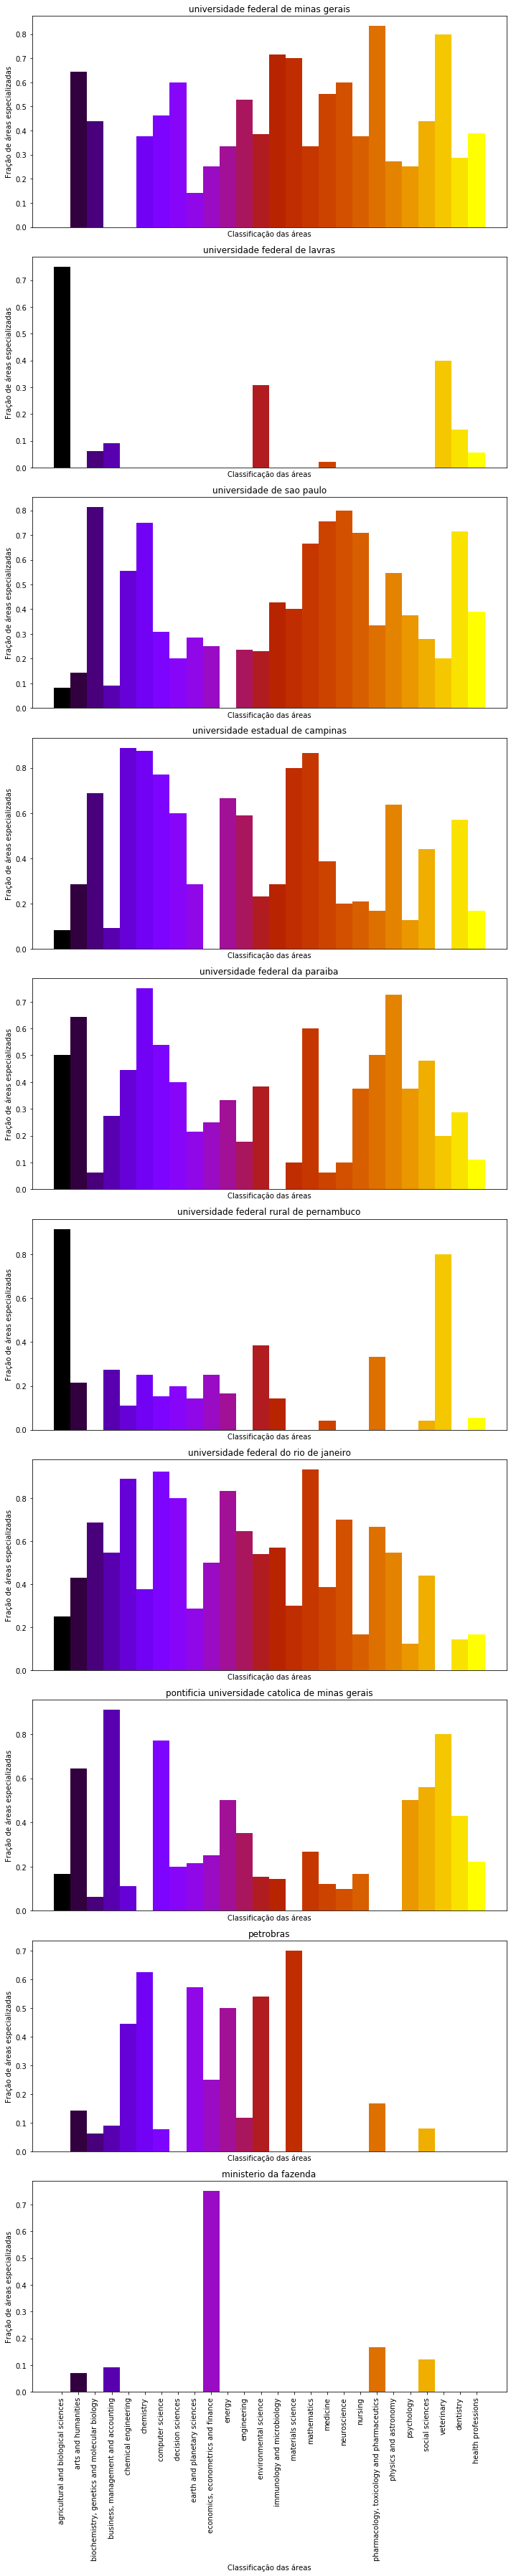

In [193]:
insts = [
    "universidade federal de minas gerais",
    "universidade federal de lavras",
    "universidade de sao paulo",
    "universidade estadual de campinas",
    "universidade federal da paraiba",
    "universidade federal rural de pernambuco",
    "universidade federal do rio de janeiro",
    "pontificia universidade catolica de minas gerais",
    "petrobras",
    "ministerio da fazenda"
]

unique = areas["Classification"].unique()[1:]

color = cmx.inferno_r(np.linspace(0.1, 1, 26))
fig = plt.figure()

for i in range(len(insts)):
    uni = insts[i]
    areas_list = list()
    for a in unique:
        if (uni, a) in macro:
            areas_list.append(macro[(uni, a)])
        else:
            areas_list.append(0)

    sub = fig.add_subplot(10,1,i+1)
    plt.bar(unique, areas_list, color=colorg, width=1.0)
    plt.xticks(rotation=90)
    plt.title(uni)
    plt.ylabel("Fração de áreas especializadas")
    plt.xlabel("Classificação das áreas")
    if i < 9:
        sub.set_xticks([])
    
fig.tight_layout()
plt.show()

In [192]:
cm = cmx.get_cmap('gnuplot', 26)
colorg = cm(np.linspace(0, 1, 26))

e de municípios/estados/regiões

### Plots:
    1. Áreas de maior atuação das principais instituições do país
    2. Mapa dos municípios/estados coloridos pelo RCA de uma área específica

E áreas urbanas

"First, we infer the country in which each affiliation-city pair is located; second, for each country, we compute a geographic distance matrix (using Vicenty’s formula) connecting each pair of cities; and lastly we use hierarchical clustering to define the different urban areas with the additional constraint that the maximum distance within each cluster has to be less than 50 km."